In [2]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.7/914.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [3]:
from ultralytics import YOLO
import cv2
import os
import torch
import numpy as np
from transformers import SamProcessor, SamModel, SamConfig
import matplotlib.pyplot as plt


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def keyboard_bbox(image_path): #returns bounding box coordinates of keyboard
    model = YOLO("/content/drive/MyDrive/000000_KNR_OD_FINAL/yolov8n.pt")  # replace with 'yolov8s.pt' for better accuracy

    image = cv2.imread(image_path)
    result = model(image)
    for r in result:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            conf = box.conf[0]
            cls = int(box.cls[0])
            label = model.names[cls]
            if "keyboard" in label.lower():
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image, f"{label} {conf:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

                # Convert BGR image to RGB
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Display the image using matplotlib
                plt.imshow(image_rgb)
                plt.title("Detected Keyboard")
                plt.axis('off')
                plt.show()
                return (x1, y1, x2, y2)

In [7]:
pip install patchify

In [8]:
from patchify import patchify
from PIL import Image, ImageOps

patch_size = 256
step = 256

def make_square(image):
    image_pil = Image.fromarray(image)
    return np.array(ImageOps.pad(image_pil, (max(image_pil.size), max(image_pil.size)), color=0))

def transform_image(image_path, bbox):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    x1, y1, x2, y2 = bbox
    image = image[y1:y2, x1:x2]
    image = make_square(image)
    image = cv2.resize(image, (512, 512))
    patches = patchify(image, (patch_size, patch_size), step=step)
    patches = patches.reshape(-1, patch_size, patch_size)
    print(patches.shape)
    return patches

In [9]:
def mask_from_patches(patches, model, processor, input_points):
    patches = [Image.fromarray(patches).convert('RGB') for patches in patches]
    fig, axes = plt.subplots(1, len(patches), figsize=(15, 15))
    for ax, patch in zip(axes, patches):
        ax.imshow(patch)
        ax.axis('off')
    plt.show()
    mask_patches = []
    for patch in patches:
        inputs = processor(patch, return_tensors = 'pt', input_points = input_points)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs, multimask_output = False)
        single_patch_mask = torch.sigmoid(outputs.pred_masks.squeeze(1))
        single_patch_mask = single_patch_mask.cpu().numpy().squeeze()
        single_patch_mask = (single_patch_mask > 0.5).astype(np.uint8)
        mask_patches.append(single_patch_mask)
    fig, axes = plt.subplots(1, len(mask_patches), figsize=(15, 15))
    for ax, patch in zip(axes, mask_patches):
        ax.imshow(patch)
        ax.axis('off')
    plt.show()
    mask = np.zeros((512, 512))
    for i in range(0, 512, step):
        for j in range(0, 512, step):
            mask[i:i+patch_size, j:j+patch_size] = mask_patches.pop(0)

    return mask

In [10]:
def bbox_img(image_path, bbox):
    image = cv2.imread(image_path)
    x1, y1, x2, y2 = bbox
    mask = np.zeros_like(image)
    mask[y1:y2, x1:x2] = 255
    mask = mask[y1:y2, x1:x2]
    mask = make_square(mask)
    mask = cv2.resize(mask, (512, 512))
    return mask

In [11]:
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)


0: 480x640 1 keyboard, 40.3ms
Speed: 15.0ms preprocess, 40.3ms inference, 256.6ms postprocess per image at shape (1, 3, 480, 640)


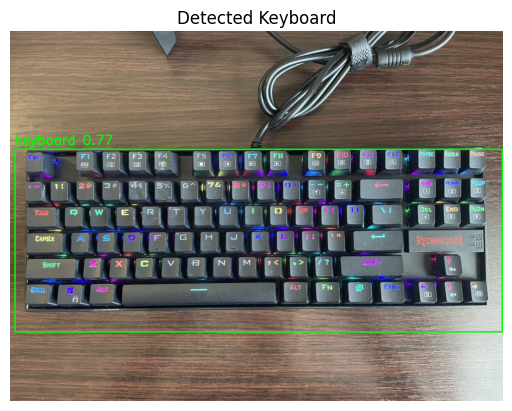

(4, 256, 256)


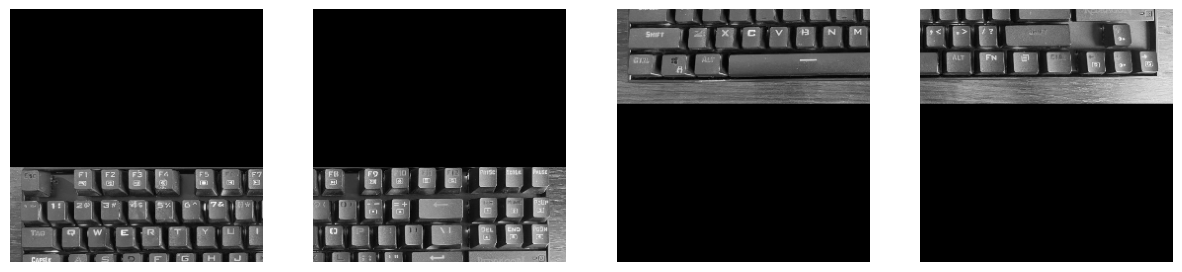

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


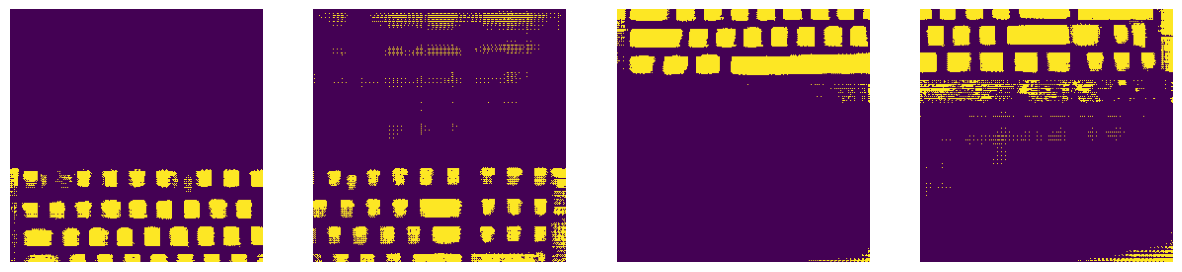

(512, 512)
(512, 512, 3)


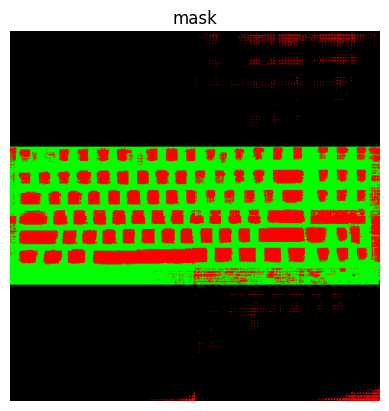

In [15]:
key_det_model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

key_det_model = SamModel(config=key_det_model_config)
key_det_model.load_state_dict(torch.load("/content/drive/MyDrive/000000_KNR_OD_FINAL/key_detection_model.pth"))
key_det_model.to(device)  # Move the model to the same device as the input tensor

dir = "/content/drive/MyDrive/000000_KNR_OD_FINAL/real_testing"
paths = [os.path.join(dir, f) for f in os.listdir(dir) if "Image" in f]
masks = []
bboxes = []

for img_path in paths:
    bbox = keyboard_bbox(img_path)
    patches = transform_image(img_path, bbox)
    mask = mask_from_patches(patches, key_det_model, processor, input_points)
    bbox_im = bbox_img(img_path, bbox)
    print(mask.shape)
    print(bbox_im.shape)
    # Combine mask and bbox_im into a single picture with 3 classes
    combined_mask = np.zeros_like(bbox_im)
    combined_mask[np.all(bbox_im == [255, 255, 255], axis=-1)] = [0, 255, 0]  # Green for bbox
    combined_mask[mask == 1] = [255, 0, 0]  # Red for mask

    # Add the combined mask to the list of masks
    masks.append(combined_mask)
    plt.imshow(combined_mask)
    plt.title("mask")
    plt.axis('off')
    plt.show()

In [17]:
# Create the masks directory if it doesn't exist
masks_dir = "/content/drive/MyDrive/000000_KNR_OD_FINAL/real_testing"
os.makedirs(masks_dir, exist_ok=True)

# Define the path to save the mask
mask_paths = [os.path.join(masks_dir, img_path.split("/")[-1].replace("Image", "Segmentation")) for img_path in paths]

# Save the mask
for mask, mask_path in zip(masks, mask_paths):
    cv2.imwrite(mask_path, mask)

In [24]:
import sys
sys.path.append('/content/drive/MyDrive/000000_KNR_OD_FINAL/real_testing')